In [1]:
# 净活性值
import paddle

# 2个特征数为5的样本
X = paddle.rand(shape=[2,5])

# 含有5个参数的权重向量
w = paddle.rand(shape=[5,1])
# 偏置项
b = paddle.rand(shape=[1,1])

# 使用'paddle.matmul'实现矩阵相乘
z = paddle.matmul(X,w) + b
print("Input X:",X)
print("Weight w:", w, "\n Bais b:",b)
print("Output z:", z)


Input X: Tensor(shape=[2, 5], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.81429195, 0.81435913, 0.04396154, 0.92878813, 0.25861338],
        [0.56815416, 0.36609840, 0.94269472, 0.73500013, 0.88562769]])
Weight w: Tensor(shape=[5, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.36728987],
        [0.18831366],
        [0.20924117],
        [0.36187917],
        [0.96146584]]) 
 Bais b: Tensor(shape=[1, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.18313260]])
Output z: Tensor(shape=[2, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[1.22952437],
        [1.77548385]])


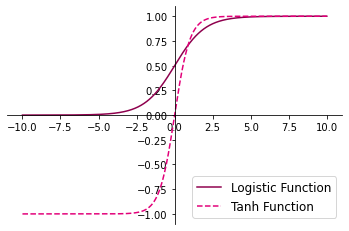

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Logistic函数
def logistic(z):
    return 1.0 / (1.0 + paddle.exp(-z))

# Tanh函数
def tanh(z):
    return (paddle.exp(z) - paddle.exp(-z)) / (paddle.exp(z) + paddle.exp(-z))

# 在[-10,10]的范围内生成10000个输入值，用于绘制函数曲线
z = paddle.linspace(-10, 10, 10000)

plt.figure()
plt.plot(z.tolist(), logistic(z).tolist(), color='#8E004D', label="Logistic Function")
plt.plot(z.tolist(), tanh(z).tolist(), color='#E20079', linestyle ='--', label="Tanh Function")

ax = plt.gca() # 获取轴，默认有4个
# 隐藏两个轴，通过把颜色设置成none
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
# 调整坐标轴位置   
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))
plt.legend(loc='lower right', fontsize='large')

plt.savefig('fw-logistic-tanh.pdf')
plt.show()

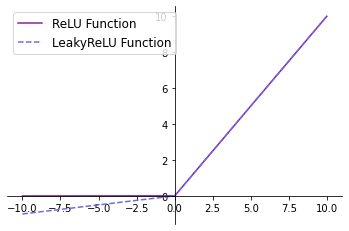

In [3]:
# ReLU型 函数

# ReLU
def relu(z):
    return paddle.maximum(paddle.to_tensor(0.), z)

# 带泄露的ReLU LeakyReLU
def leaky_relu(z, negative_slope = 0.1):
    # 当前版本paddle暂不支持直接将bool类型转成int类型，因此调用了paddle的cast函数来进行显式转换
    a1 = (paddle.cast((z>0), dtype='float32')*z)
    a2 = (paddle.cast((z<=0), dtype='float32')*(negative_slope*z))
    return a1 + a2

# 在[-10,10]的范围内生成一系列的输入值，用于绘制relu、leaky_relu的函数曲线
z = paddle.linspace(-10,10,10000)

# a1 = paddle.cast((z > 0), dtype='float32')
# c = (z > 0)
# print(c.dtype)
# print(a1) 
# paddle.cast(x, dtype) 将 x 的数据类型转换为 dtype 并输出。支持输出和输入的数据类型相同

plt.figure()
plt.plot(z.tolist(), relu(z).tolist(), color = '#862398', label = "ReLU Function")
plt.plot(z.tolist(), leaky_relu(z).tolist(), color = '#7268E0', linestyle = "--", label = "LeakyReLU Function")

ax = plt.gca()
ax.spines['top'].set_color('None')
ax.spines['right'].set_color('None')
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
plt.legend(loc = 'upper left', fontsize = 'large')
plt.savefig('fw-relu-leakyrelu.pdf')
plt.show()


基于前馈神经网络的二分类任务

In [4]:
# 数据集构建

from nndl_4.dataset import make_moons

# 采样1000个样本
n_samples = 1000
X, y = make_moons(n_samples=n_samples, shuffle = True, noise= 0.5)

num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
X_test, y_test = X[num_train+num_dev:], y[num_train+ num_dev:]

y_train = y_train.reshape([-1,1])
y_dev = y_dev.reshape([-1,1])
y_test = y_test.reshape([-1,1])


outer_circ_x.shape: [500] outer_circ_y.shape: [500]
inner_circ_x.shape: [500] inner_circ_y.shape: [500]
after concat shape: [1000]
X shape: [1000, 2]
y shape: [1000]


In [5]:
# 模型构建

from nndl_4.op import Op

# 实现线性层算子
class Linear(Op):
    def __init__(self, input_size, output_size, name, weight_init = paddle.standard_normal, bias_init = paddle.zeros):
        """
        输入：
            - input_size：输入数据维度
            - output_size：输出数据维度
            - name：算子名称
            - weight_init：权重初始化方式，默认使用'paddle.standard_normal'进行标准正态分布初始化
            - bias_init：偏置初始化方式，默认使用全0初始化
        """

        self.params = {}
        # 初始化权重
        self.params['W'] = weight_init(shape=[input_size, output_size])
        # 初始化偏置
        self.params['b'] = bias_init(shape=[1, output_size])
        self.inputs = None
        self.name = name
    
    def forward(self, inputs):
        """
        输入：
            - inputs：shape=[N,input_size], N是样本数量
        输出：
            - outputs：预测值，shape=[N,output_size]
        """
        self.inputs = inputs

        outputs = paddle.matmul(self.inputs, self.params['W']) + self.params['b']

        return outputs

In [6]:
class Logistic(Op):
    def __init__(self):
        self.inputs = None
        self.outputs = None

    def forward(self, inputs):
        """
        输入：
            - inputs: shape=[N,D]
        输出：
            - outputs：shape=[N,D]
        """
        outputs = 1.0 / (1.0 + paddle.exp(-inputs))
        self.outputs = outputs
        return outputs

In [7]:
# 实现一个两层的前馈神经网络

class Model_MLP_L2(Op):
    def __init__(self, input_size, hidden_size, output_size):
        """
        输入：
            - input_size：输入维度
            - hidden_size：隐藏层神经元数量
            - output_size：输出维度
        """
        self.fc1 = Linear(input_size, hidden_size, name="fc1")
        self.act_fn1 = Logistic()
        self.fc2 = Linear(hidden_size, output_size, name="fc2")
        self.act_fn2 = Logistic()

    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        """
        输入：
            - X：shape=[N,input_size], N是样本数量
        输出：
            - a2：预测值，shape=[N,output_size]
        """
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2
    

In [8]:
# 实例化模型
model = Model_MLP_L2(input_size = 5, hidden_size = 10, output_size = 1)
# 随机生成一条长度为5的数据
X = paddle.rand(shape=[1,5])
result = model(X)
print("result: ", result)

result:  Tensor(shape=[1, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.91985434]])


In [9]:
# 损失函数

# 实现交叉熵损失函数
class BinaryCrossEntropyLoss(Op):
    def __init__(self, model):
        self.predicts = None
        self.labels = None
        self.num = None
        self.model = model

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)
    
    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, 1]，N为样本数量
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        self.predicts = predicts
        self.labels = labels
        self.num = self.predicts.shape[0]

        loss = -1. / self.num * (paddle.matmul(self.labels.t(), paddle.log(self.predicts))
                                 + paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))
        
        loss = paddle.squeeze(loss, axis=1)
        return loss
    
    def backward(self):
        # 计算损失函数对模型预测的导数
        loss_grad_predicts = -1.0 * (self.labels/self.predicts - (1-self.labels)/(1-self.predicts)) / self.num
        # 梯度反向传播
        return model.backward(loss_grad_predicts)

In [10]:
# Logistic 算子 （包括反向函数）
class Logistic(Op):
    def __init__(self):
        self.inputs = None
        self.outputs = None
        self.params = None

    def forward(self, inputs):
        outputs = 1.0 / (1.0 + paddle.exp(-inputs))
        self.outputs = outputs
        return outputs
    
    def backward(self, grads):
        # 计算Logistic激活函数对输入的导数
        out_grad_inputs = paddle.multiply(self.outputs, (1.0 -self.outputs))
        return paddle.multiply(out_grad_inputs, grads)

In [11]:
class Linear(Op):
    def __init__(self, input_size, output_size, name, weight_init = paddle.standard_normal, bias_init = paddle.zeros):
        self.params = {}
        self.params['W'] = weight_init(shape=[input_size, output_size])
        self.params['b'] = bias_init(shape=[1, output_size])
        self.inputs = None
        self.grads = {}
        self.name = name

    def forward(self, inputs):
        self.inputs = inputs
        outputs = paddle.matmul(self.inputs, self.params['W']) + self.params['b']
        return outputs
    
    def backward(self, grads):
        """
        输入：
            - grads：损失函数对当前层输出的导数
        输出：
            - 损失函数对当前层输入的导数
        """
        self.grads['W'] = paddle.matmul(self.inputs.T, grads)
        self.grads['b'] = paddle.sum(grads, axis=0)

        # 线性层输入的梯度
        return paddle.matmul(grads, self.params['W'].T)

In [12]:
class Model_MLP_L2(Op):
    def __init__(self, input_size, hidden_size, output_size):
        # 线性层
        self.fc1 = Linear(input_size, hidden_size, name="fc1")
        # Logistic 激活函数层
        self.act_fn1 = Logistic()
        self.fc2 = Linear(hidden_size, output_size, name="fc2")
        self.act_fn2 = Logistic()
        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2]
    
    def __call__(self, X):
        return self.forward(X)
    
    # 前向计算
    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2
    
    # 反向计算
    def backward(self, loss_grad_a2):
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2)
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_inputs = self.fc1.backward(loss_grad_z1)
    
        

In [13]:
from nndl_4.opitimizer import Optimizer

class BatchBGD(Optimizer):
    def __init__(self, init_lr, model):
        super(BatchBGD, self).__init__(init_lr=init_lr, model=model)

    def step(self):
        # 参数更新
        for layer in self.model.layers:
            # 遍历所有层
            if isinstance(layer.params, dict):
                for key in layer.params.keys():
                    layer.params[key] = layer.params[key] - self.init_lr * layer.grads[key]

In [14]:
import os

class RunnerV2_1(object):
    def __init__(self, model, optimizer, metric, loss_fn, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn

        # 记录训练过程中的评估指标变化情况
        self.train_scores = []
        self.dev_scores = []

        # 记录训练过程中评价指标变化情况
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_epochs = kwargs.get("log_epochs", 100)

        # 传入模型保存路径
        save_dir = kwargs.get("save_dir", None)

        # 记录全局最优指标
        best_score = 0 
        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            X, y = train_set
            # 获取模型预测
            logits = self.model(X)
            # 计算交叉熵损失
            trn_loss = self.loss_fn(logits, y) # return a tensor

            self.train_loss.append(trn_loss.item())
            # 计算评估指标
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score)

            self.loss_fn.backward()

            # 参数更新
            self.optimizer.step()

            dev_score, dev_loss = self.evaluate(dev_set)
            # 如果当前指标为最优指标，保存该模型
            if dev_score > best_score:
                print(f"[Evaluate] best accuracy performance has been updated: {best_score: .5f} -->{dev_score: 5f}")
                best_score = dev_score
                if save_dir:
                    self.save_model(save_dir)
            
            if log_epochs and epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}/{num_epochs}, loss: {trn_loss.item()}")

    def evaluate(self, data_set):
        X, y = data_set
        # 计算模型输出
        logits = self.model(X)
        # 计算损失函数
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        # 计算评估指标
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss
    
    def predict(self,X):
        return self.model(X)
    
    def save_model(self, save_dir):
        
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                paddle.save(layer.params, os.path.join(save_dir, layer.name + ".pdparams"))
    
    def load_model(self, model_dir):
        # 获取所有层参数名称和保存路径之间的对应关系
        model_file_name = os.listdir(model_dir)
        name_file_dict = {}
        for file_name in model_file_name:
            name = file_name.replace(".pdparams","")
            name_file_dict[name] = os.path.join(model_dir, file_name)
        # 加载每层参数
        for layer in self.model.layers: # 遍历所有层
            if isinstance(layer.params, dict):
                name = layer.name
                file_path = name_file_dict[name]
                layer.params = paddle.load(file_path)

In [15]:
# 模型训练

from nndl_4.metric import accuracy

paddle.seed(123)
epoch_num = 1000
model_save_dir = "model_RunnerV2_1"

# 输入层神经元数量为2
input_size = 2
# 隐藏层神经元数量为5
hidden_size = 5
# 输出层神经元数量为1
output_size = 1
# 定义网络
model = Model_MLP_L2(input_size=input_size,hidden_size=hidden_size,output_size=output_size)

# 损失函数
loss_fn = BinaryCrossEntropyLoss(model=model)

# 优化器
lr = 0.2
optimizer = BatchBGD(init_lr=lr, model=model)

# 评价指标
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV2_1(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)

runner.train([X_train, y_train], [X_dev, y_dev], num_epochs = epoch_num, log_epochs = 50, save_dir = model_save_dir)

[Evaluate] best accuracy performance has been updated:  0.00000 --> 0.456250
[Train] epoch: 0/1000, loss: 0.9206227660179138
[Evaluate] best accuracy performance has been updated:  0.45625 --> 0.462500
[Evaluate] best accuracy performance has been updated:  0.46250 --> 0.468750
[Evaluate] best accuracy performance has been updated:  0.46875 --> 0.475000
[Evaluate] best accuracy performance has been updated:  0.47500 --> 0.475000
[Evaluate] best accuracy performance has been updated:  0.47500 --> 0.481250
[Evaluate] best accuracy performance has been updated:  0.48125 --> 0.493750
[Evaluate] best accuracy performance has been updated:  0.49375 --> 0.518750
[Evaluate] best accuracy performance has been updated:  0.51875 --> 0.550000
[Evaluate] best accuracy performance has been updated:  0.55000 --> 0.562500
[Evaluate] best accuracy performance has been updated:  0.56250 --> 0.575000
[Evaluate] best accuracy performance has been updated:  0.57500 --> 0.581250
[Evaluate] best accuracy per

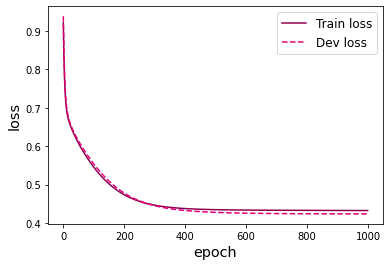

In [16]:
# 打印训练集和验证集的损失

plt.figure()
plt.plot(range(epoch_num), runner.train_loss, color="#8E004D", label="Train loss")
plt.plot(range(epoch_num), runner.dev_loss, color="#E20079", linestyle='--', label="Dev loss")
plt.xlabel("epoch", fontsize = 'x-large')
plt.ylabel("loss", fontsize = "x-large")
plt.legend(fontsize =  'large')
plt.savefig('fw-loss2.pdf')
plt.show()

In [17]:
# 加载训练好的模型
runner.load_model(model_dir=model_save_dir)
score, loss = runner.evaluate([X_test, y_test])
# print(f"[Test] score/loss: {score:.4f}/{loss:.4f}")
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8000/0.4368


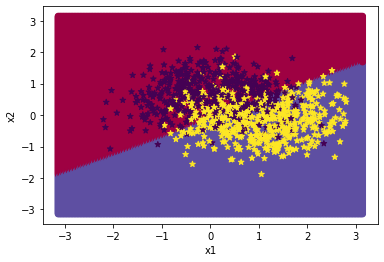

In [18]:
import math

# 均匀生成40000个数据点
x1, x2 = paddle.meshgrid(paddle.linspace(-math.pi, math.pi, 200), paddle.linspace(-math.pi, math.pi, 200))
x = paddle.stack([paddle.flatten(x1), paddle.flatten(x2)], axis=1)

y = runner.predict(x)
y = paddle.squeeze(paddle.cast((y>=0.5), dtype='float32'), axis= -1)

# 绘制类别区域
plt.ylabel('x2')
plt.xlabel('x1')

plt.scatter(x[:, 0].tolist(), x[:, 1].tolist(), c=y.tolist(), cmap=plt.cm.Spectral)

plt.scatter(X_train[:, 0].tolist(), X_train[:,1].tolist(), marker='*', c= paddle.squeeze(y_train, axis=-1).tolist())
plt.scatter(X_dev[:, 0].tolist(), X_dev[:,1].tolist(), marker='*', c= paddle.squeeze(y_dev, axis=-1).tolist())
plt.scatter(X_test[:, 0].tolist(), X_test[:, 1].tolist(), marker='*', c= paddle.squeeze(y_test, axis=-1).tolist())

In [19]:
# 自动梯度计算和预定义算子

import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn.initializer import Constant, Normal, Uniform

class Model_MLP_L2_V2(paddle.nn.Layer):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V2, self).__init__()
        # 使用'paddle.nn.Linear'定义线性层。
        # 其中第一个参数（in_features）为线性层输入维度；第二个参数（out_features）为线性层输出维度
        # weight_attr为权重参数属性，这里使用'paddle.nn.initializer.Normal'进行随机高斯分布初始化
        # bias_attr为偏置参数属性，这里使用'paddle.nn.initializer.Constant'进行常量初始化
        self.fc1 = nn.Linear(input_size, hidden_size,
                             weight_attr = paddle.ParamAttr(initializer=Normal(mean=0., std=1.)),
                             bias_attr = paddle.ParamAttr(initializer=Constant(value=0.0)))
        self.fc2 = nn.Linear(hidden_size, output_size,
                             weight_attr = paddle.ParamAttr(initializer=Normal(mean=0., std=1.)),
                             bias_attr = paddle.ParamAttr(initializer=Constant(value=0.0)))
        # 使用'paddle.nn.functional.sigmoid'定义 Logistic 激活函数
        self.act_fn = F.sigmoid

    # 前向计算
    def forward(self, inputs):
        z1 = self.fc1(inputs)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        return a2

In [20]:
class RunnerV2_2(object):
    def __init__(self, model, optimizer, metric, loss_fn, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn

        # 记录训练过程中的评估指标变化情况
        self.train_scores = []
        self.dev_scores = []

        # 记录训练过程中的损失变化情况
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        # 将模型切换为训练模式
        self.model.train()

        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_epochs = kwargs.get("log_epochs", 100)
        # 传入模型保存路径，如果没有传入值则默认为"best_model.pdparams"
        save_path = kwargs.get("save_path", "best_model_RunnerV2_2.pdparams")

        # log打印函数，如果没有传入则默认为"None"
        custom_print_log = kwargs.get("custom_print_log", None)

        # 记录全局最优指标
        best_score = 0
        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            X, y = train_set
            # 获取模型预测
            logits = self.model(X)
            # 计算交叉熵损失
            trn_loss = self.loss_fn(logits, y)
            self.train_loss.append(trn_loss.item())

            # 计算评估指标
            trn_scores = self.metric(logits, y).item()
            self.train_scores.append(trn_scores)
            
            # 自动计算参数梯度
            trn_loss.backward()
            if custom_print_log is not None:
                # 打印每一层的梯度
                custom_print_log(self)

            # 参数更新
            self.optimizer.step()
            # 清空梯度
            self.optimizer.clear_grad()

            dev_score, dev_loss = self.evaluate(dev_set)

            # 如果当前指标为最优指标，保存该模型

            if dev_score > best_score:
                self.save_model(save_path)
                print(f"[Evaluate] best accuracy performance has been updated: {best_score:.5f} --> {dev_score: .5f}")
                best_score = dev_score

            if log_epochs and epoch % log_epochs == 0:
                print(f"[Train] epoch :{epoch}/{num_epochs}, loss:{trn_loss.item()}")

    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def evaluate(self, data_set):
        # 将模型切换为评估模式
        self.model.eval()
        X, y = data_set
        # 计算模型输出
        logits = self.model(X)
        # 计算损失函数
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        # 计算评价指标
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss

    @paddle.no_grad()
    def predict(self, X):
        # 将模型切换为评估模式
        self.model.eval()
        return self.model(X)
    
    # 使用'model.state_dict()'获取模型参数，并进行保存
    def save_model(self, saved_path):
        paddle.save(self.model.state_dict(), saved_path)

    # 使用'model.set_state_dict'加载模型参数
    def load_model(self, model_path):
        state_dict = paddle.load(model_path)
        self.model.set_state_dict(state_dict)

In [21]:
# 模型训练

input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2_V2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 设置损失函数
loss_fn = F.binary_cross_entropy

# 设置优化器
learning_rate = 0.2
optimizer = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())

# 设置评价函数
metric = accuracy

# 其他参数
epoch_num = 100
save_path = 'best_model_RunnerV2_2.pdparams'

# 实例化RunnerV2_2类，并传入训练配置
runner = RunnerV2_2(model, optimizer, metric, loss_fn)
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=epoch_num, log_epochs=50, save_path='best_model_RunnerV2_2.pdparams')


[Evaluate] best accuracy performance has been updated: 0.00000 -->  0.45625
[Train] epoch :0/100, loss:1.0245740413665771
[Evaluate] best accuracy performance has been updated: 0.45625 -->  0.46875
[Evaluate] best accuracy performance has been updated: 0.46875 -->  0.49375
[Evaluate] best accuracy performance has been updated: 0.49375 -->  0.51875
[Evaluate] best accuracy performance has been updated: 0.51875 -->  0.56875
[Evaluate] best accuracy performance has been updated: 0.56875 -->  0.59375
[Evaluate] best accuracy performance has been updated: 0.59375 -->  0.63750
[Evaluate] best accuracy performance has been updated: 0.63750 -->  0.65625
[Evaluate] best accuracy performance has been updated: 0.65625 -->  0.67500
[Evaluate] best accuracy performance has been updated: 0.67500 -->  0.71250
[Evaluate] best accuracy performance has been updated: 0.71250 -->  0.71875
[Evaluate] best accuracy performance has been updated: 0.71875 -->  0.73125
[Evaluate] best accuracy performance has b

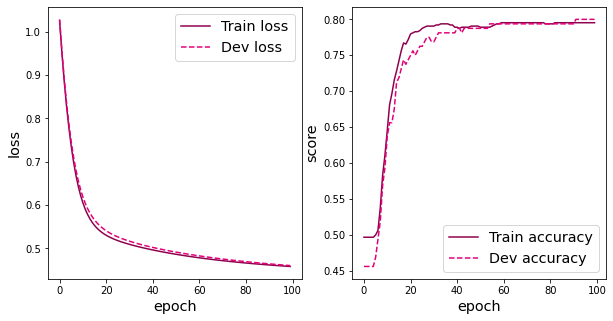

In [22]:
# 可视化观察训练集与验证集的指标变化情况
def plot(runner, fig_name):
    plt.figure(figsize=(10,5))
    epochs = [i for i in range(len(runner.train_scores))]

    plt.subplot(1,2,1)
    plt.plot(epochs, runner.train_loss, color='#8E004D', label="Train loss")
    plt.plot(epochs, runner.dev_loss, color='#E20079', linestyle='--', label="Dev loss")
    # 绘制坐标轴和图例
    plt.xlabel("epoch", fontsize ='x-large')
    plt.ylabel("loss", fontsize ='x-large')
    plt.legend(loc = 'upper right', fontsize ='x-large')

    plt.subplot(1,2,2)
    plt.plot(epochs, runner.train_scores, color='#8E004D', label="Train accuracy")
    plt.plot(epochs, runner.dev_scores, color='#E20079', linestyle='--', label="Dev accuracy")
    # 绘制坐标轴和图例
    plt.xlabel("epoch", fontsize ='x-large')
    plt.ylabel("score", fontsize ='x-large')
    plt.legend(loc = 'lower right', fontsize ='x-large')

    plt.savefig(fig_name)
    plt.show()

plot(runner, 'fw-acc.pdf')



In [23]:
# 模型评价
runner.load_model("best_model_RunnerV2_2.pdparams")
score, loss = runner.evaluate([X_test, y_test])
print(f"[Test] score/loss: {score:.4f}/{loss:.4f}")

[Test] score/loss: 0.7900/0.4624


In [24]:
# 优化问题
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn.initializer import Constant, Normal, Uniform

class Model_MLP_L2_V4(paddle.nn.Layer):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V4, self).__init__()
        # 使用'paddle.nn.Linear'定义线性层。
        # 其中in_features为线性层输入维度；out_features为线性层输出维度
        # weight_attr为权重参数属性
        # bias_attr为偏置参数属性
        self.fc1 = nn.Linear(input_size, hidden_size,
                             weight_attr=paddle.ParamAttr(initializer=Constant(value=0.0)),
                             bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        # Constant()用于初始化输入变量的值，默认值为 0
        self.fc2 = nn.Linear(hidden_size, output_size,
                             weight_attr=paddle.ParamAttr(initializer=Constant(value=0.0)),
                             bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        
        # 使用'paddle.nn.functional.sigmoid'定义 Logistic 激活函数
        self.act_fn = F.sigmoid

    # 前向计算
    def forward(self, inputs):
        z1 = self.fc1(inputs)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        return a2

In [25]:
def print_weights(runner):
    print('The weights of the Layers:')
    for item in runner.model.sublayers():
        print(item.full_name())
        for param in item.parameters():
            print(param.numpy())
        

In [26]:
# 设置模型
input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2_V4(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 设置损失函数
loss_fn = F.binary_cross_entropy

# 设置优化器
learning_rate = 0.2 # 5e-2
optimizer = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())

# 设置评价指标
metric = accuracy

# 其他参数
epoch = 2000
saved_path = 'best_model_Model_MLP_L2_V4.pdparams'

# 实例化RunnerV2类，并传入训练配置
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=5, log_epochs=50, save_path='best_model_Model_MLP_L2_V4.pdparams', custom_print_log=print_weights)

The weights of the Layers:
linear_2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0.]
linear_3
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[0.]
[Evaluate] best accuracy performance has been updated: 0.00000 -->  0.54375
[Train] epoch :0/5, loss:0.6931471824645996
The weights of the Layers:
linear_2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0.]
linear_3
[[-0.0003125]
 [-0.0003125]
 [-0.0003125]
 [-0.0003125]
 [-0.0003125]]
[-0.000625]
The weights of the Layers:
linear_2
[[-3.8846892e-06 -3.8846892e-06 -3.8846892e-06 -3.8846892e-06
  -3.8846892e-06]
 [ 3.0391473e-06  3.0391473e-06  3.0391473e-06  3.0391473e-06
   3.0391473e-06]]
[4.3335234e-08 4.3335234e-08 4.3335234e-08 4.3335234e-08 4.3335234e-08]
linear_3
[[-0.00058985]
 [-0.00058985]
 [-0.00058985]
 [-0.00058985]
 [-0.00058985]]
[-0.00117969]
The weights of the Layers:
linear_2
[[-1.1221789e-05 -1.1221789e-05 -1.1221789e-05 -1.1221789e-05
  -1.1221789e-05]
 [ 8.7734361e-06  8.7734361e-06  8.7734361e-06  8.7734361e-06
   8.7734361e-06]

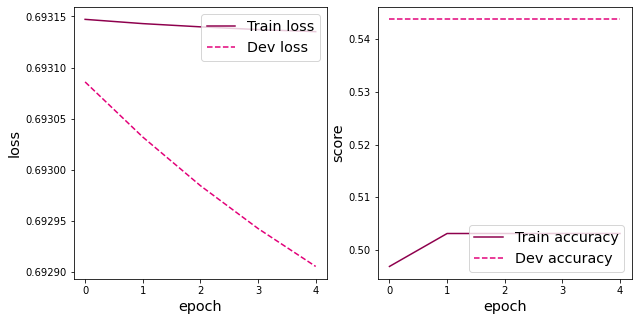

In [27]:
plot(runner, "fw-zero.pdf")

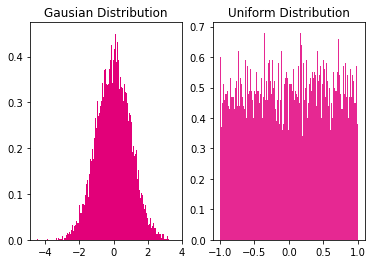

In [28]:
import paddle
import matplotlib.pyplot as plt

# 使用'paddle.normal'实现高斯分布采样，其中'mean'为高斯分布的均值，'std'为高斯分布的标准差，'shape'为输出形状
gausian_weights = paddle.normal(mean=0.0, std=1.0, shape=[10000])
# 使用'paddle.uniform'实现在[min,max)范围内的均匀分布采样，其中'shape'为输出形状
uniform_weights = paddle.uniform(shape=[10000], min=-1.0,max=1.0)

# 绘制两种参数分布
plt.figure()
plt.subplot(1,2,1)
plt.title('Gausian Distribution')
plt.hist(gausian_weights, bins=200, density=True, color='#E20079')
# plt.hist()直方图

plt.subplot(1,2,2)
plt.title('Uniform Distribution')
plt.hist(uniform_weights, bins=200, density=True, color='#E62892')
plt.savefig('fw-gausian-uniform.pdf')
plt.show()


In [35]:
# 定义多层前馈神经网络
class Model_MLP_L5(paddle.nn.Layer):
    def __init__(self, input_size, output_size, act='sigmoid', w_init=Normal(mean=0.0, std=0.01), b_init=Constant(value=1.0)):
        super(Model_MLP_L5, self).__init__()
        self.fc1 = paddle.nn.Linear(input_size, 3)
        self.fc2 = paddle.nn.Linear(3, 3)
        self.fc3 = paddle.nn.Linear(3, 3)
        self.fc4 = paddle.nn.Linear(3, 3)
        self.fc5 = paddle.nn.Linear(3, output_size)

        # 定义网络使用的激活函数
        if act == 'sigmoid':
            self.act = F.sigmoid
        elif act == 'relu':
            self.act = F.relu
        elif act == 'lrelu':
            self.act = F.leaky_relu
        else:
            raise ValueError("Please enter sigmod relu or lrelu!")
        
        # 初始化线性层权重和偏置参数
        self.init_weights(w_init, b_init)

    # 初始化线性层权重和偏置参数
    def init_weights(self, w_init, b_init):
        # 使用'named_sublayers'遍历所有网络层
        for n, m in self.named_sublayers():
            if isinstance(m, nn.Linear):
                w_init(m.weight)
                b_init(m.bias)

    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act(outputs)
        outputs = self.fc2(outputs)
        outputs = self.act(outputs)
        outputs = self.fc3(outputs)
        outputs = self.act(outputs)
        outputs = self.fc4(outputs)
        outputs = self.act(outputs)
        outputs = self.fc5(outputs)
        outputs = F.sigmoid(outputs)
        return outputs

In [36]:
def print_grads(runner):
    print('The gradient of the Layers:')
    for item in runner.model.sublayers():
        if len(item.parameters())==2:
            print(item.full_name(), paddle.norm(item.parameters()[0].grad, p=2.).numpy()[0])

In [37]:
paddle.seed(102)

#学习率大小
lr = 0.01

# 定义网络，激活函数使用sigmoid
model = Model_MLP_L5(input_size=2, output_size=1, act='sigmoid')

# 定义优化器
optimizer = paddle.optimizer.SGD(learning_rate=lr, parameters=model.parameters())

# 定义损失函数
loss_fn = F.binary_cross_entropy

# 定义评价指标
metric = accuracy

# 指定梯度打印函数
custom_print_log = print_grads

# 实例化RunnerV2_2类
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

In [39]:
# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=1, log_epochs=None,
             save_path="best_Model_MLP_L5_sigmoid.pdparams", custom_print_log=custom_print_log)

The gradient of the Layers:
linear_4 8.984266e-12
linear_5 4.8695923e-09
linear_6 1.3717405e-06
linear_7 0.00035362793
linear_8 0.29530314
[Evaluate] best accuracy performance has been updated: 0.00000 -->  0.45625


In [40]:
paddle.seed(102)
lr = 0.01 # 学习率大小

# 定义网络，激活函数使用relu
model = Model_MLP_L5(input_size=2, output_size=1, act='relu')

# 定义优化器
optimizer = paddle.optimizer.SGD(learning_rate=lr, parameters=model.parameters())

# 定义损失函数
# 定义损失函数，这里使用交叉熵损失函数
loss_fn = F.binary_cross_entropy

# 定义评估指标
metric = accuracy

# 实例化Runner
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=1, log_epochs=None,
             save_path='best_Model_MLP_L5_relu.pdparams', custom_print_log=custom_print_log)

The gradient of the Layers:
linear_9 3.8134944e-09
linear_10 5.333511e-07
linear_11 3.869243e-05
linear_12 0.002350475
linear_13 0.40641433
[Evaluate] best accuracy performance has been updated: 0.00000 -->  0.45625


In [41]:
# 定义网络，并使用较大的负值初始化偏置
model = Model_MLP_L5(input_size=2, output_size=1, act='relu', b_init=Constant(value=-8.0))

# 实例化RunnerV2_2类
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=1, log_epochs=0,
             save_path='best_Model_MLP_L5_Negative_value.pdparams', custom_print_log=custom_print_log)

The gradient of the Layers:
linear_14 0.0
linear_15 0.0
linear_16 0.0
linear_17 0.0
linear_18 0.0
[Evaluate] best accuracy performance has been updated: 0.00000 -->  0.54375


In [42]:
# 重新定义网络，使用Leaky ReLU激活函数
model = Model_MLP_L5(input_size=2, output_size=1, act='lrelu', b_init=Constant(value=-8.0))

# 实例化RunnerV2_2类
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=1, log_epochs=0,
             save_path='best_Model_MLP_L5_lrelu.pdparams', custom_print_log=custom_print_log)

The gradient of the Layers:
linear_19 1.784793e-16
linear_20 3.591522e-13
linear_21 1.6430012e-09
linear_22 7.803936e-06
linear_23 0.068799905
[Evaluate] best accuracy performance has been updated: 0.00000 -->  0.54375
